Sube el CSV (arrastra / selecciona):


Saving vehiculos.csv to vehiculos (9).csv

Dimensiones iniciales: (4340, 8)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner



Clases de transmission (ejemplo): ['manual' 'automatic']

Dimensiones tras limpieza básica: (3577, 9)

Filtrando selling_price entre 51786.64 y 2675000.00 (1%-99%)
Dimensiones tras filtrar outliers: (3506, 9)

Numéricas: ['year', 'km_driven']
Categóricas: ['fuel', 'seller_type', 'transmission', 'owner', 'brand']

Tamaños: X_train (2804, 7) X_test (702, 7)

Usando grado polinomial = 2

Entrenando modelo polinomial (RidgeCV)... esto puede tardar un poco dependiendo del tamaño del dataset
Entrenamiento finalizado.

Métricas (en escala original):
MSE:  33,183,837,727.57
RMSE: 182,164.32
MAE:  119,314.58
R²:   0.7340


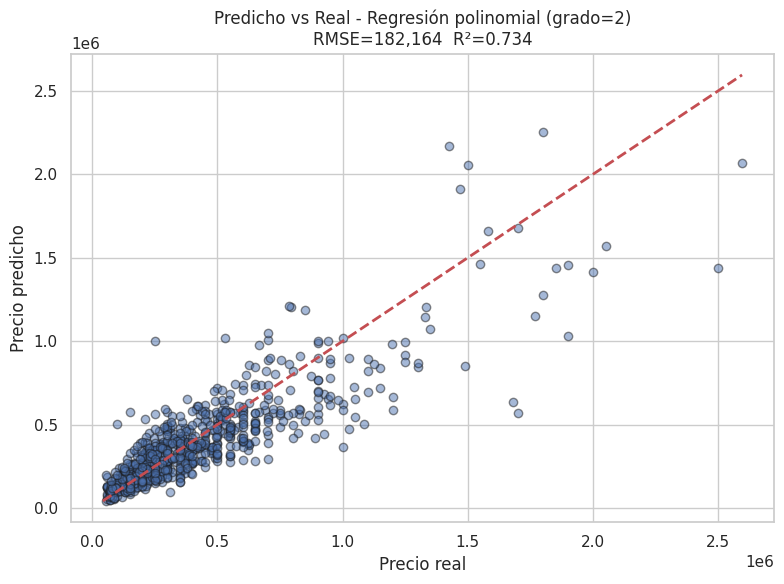

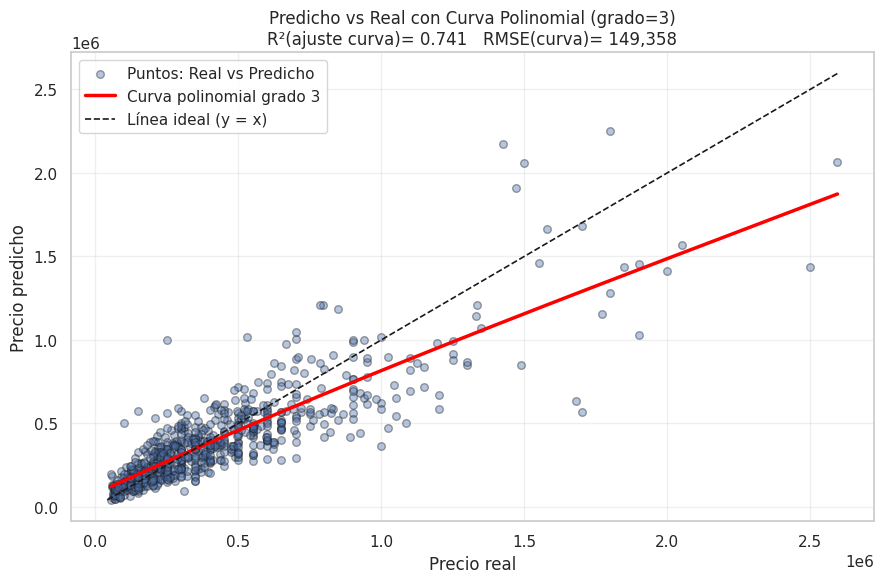

Coeficientes polinomio (mayor a menor grado): [ 0.00000000e+00 -0.00000000e+00  7.86633000e-01  7.94097467e+04]


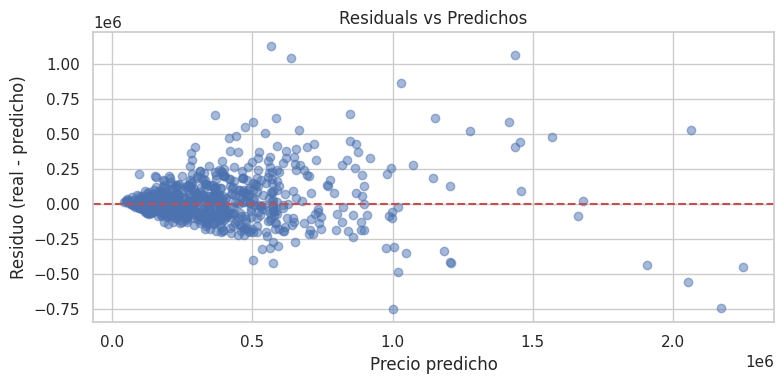

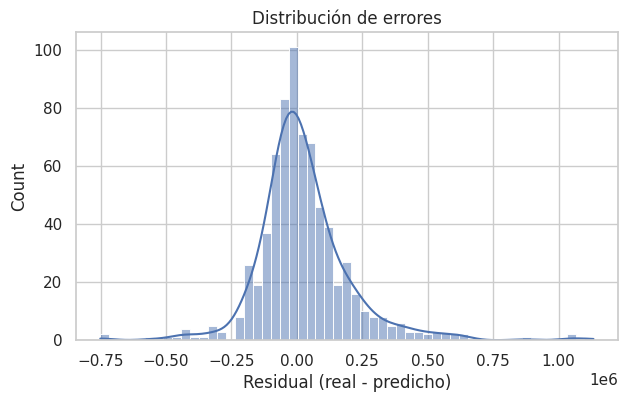

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


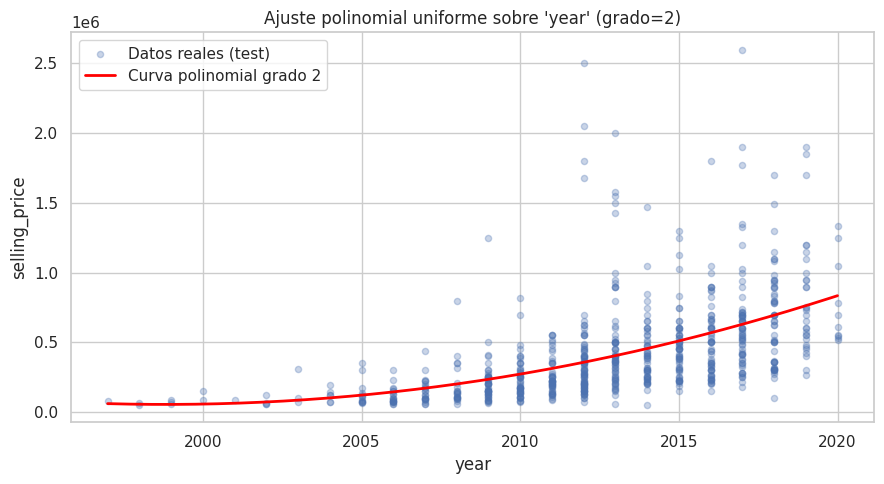


NOTAS:
- Si ves overfitting (R² muy alto en train y bajo en test), reduce grado o aumenta regularización (alfa).
- Si target está muy sesgado, usar log1p puede mejorar ajuste y métricas (ya aplicado en esta ejecución si use_log_target=True).
- Puedes probar degree=1 (lineal), 2, 3, etc. pero cuidado con degree alto (explosion de features).
- Para interpretar coeficientes en modelos con OneHotEncoder y PolynomialFeatures, conviene extraer nombres de features transformadas.

Fin del pipeline polinomial. Cambia 'degree' o 'use_log_target' arriba y vuelve a ejecutar para experimentar.


In [34]:
# ==============================
# REGRESIÓN POLINOMIAL - COCHES USADOS
# ==============================

# ===== 0) LIBRERÍAS =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ===== 1) SUBIR Y CARGAR DATASET =====
print("Sube el CSV (arrastra / selecciona):")
uploaded = files.upload()

csv_name = list(uploaded.keys())[0]
df = pd.read_csv(csv_name)

# Normalizar nombres de columnas
df.columns = df.columns.str.lower().str.strip()

print("\nDimensiones iniciales:", df.shape)
display(df.head())

# ===== 2) LIMPIEZA BÁSICA =====
# Quitar duplicados
df = df.drop_duplicates().copy()

# Nos aseguramos que las columnas claves existan y sean numéricas
for col in ['selling_price', 'year', 'km_driven']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Eliminamos filas sin target o sin features esenciales
df = df.dropna(subset=['selling_price', 'year', 'km_driven']).copy()

# Normalizar y limpiar strings
for c in ['fuel', 'seller_type', 'transmission', 'owner', 'name']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.lower()

# Revisar clases de transmission (solo para info)
if 'transmission' in df.columns:
    print("\nClases de transmission (ejemplo):", df['transmission'].unique()[:10])

# (Opcional) crear 'brand' desde 'name'
if 'name' in df.columns:
    df['brand'] = df['name'].astype(str).str.split().str[0].str.lower()
else:
    df['brand'] = 'unknown'

print("\nDimensiones tras limpieza básica:", df.shape)

# ===== 3) ELIMINAR OUTLIERS (RANGO INTERCUANTÍLICO O PERCENTILES) =====
# Usamos percentiles 1%-99% para cortar extremos en selling_price (ajusta si es necesario)
low_p, high_p = df['selling_price'].quantile([0.01, 0.99])
print(f"\nFiltrando selling_price entre {low_p:.2f} y {high_p:.2f} (1%-99%)")
df = df[(df['selling_price'] >= low_p) & (df['selling_price'] <= high_p)].copy()
print("Dimensiones tras filtrar outliers:", df.shape)

# ===== 4) DEFINIR X, y =====
target = 'selling_price'
# FEATURES numéricas y categóricas (ajusta si no existen)
num_cols = [c for c in ['year', 'km_driven'] if c in df.columns]
cat_cols = [c for c in ['fuel', 'seller_type', 'transmission', 'owner', 'brand'] if c in df.columns]

print("\nNuméricas:", num_cols)
print("Categóricas:", cat_cols)

X = df[num_cols + cat_cols].copy()
y = df[target].copy()

# (Opcional) Log-transform de y para mejorar homoscedasticidad
use_log_target = True   # <-- cambialo a False si prefieres no transformar el target
if use_log_target:
    y = np.log1p(y)   # trabajar con log(y+1)

# ===== 5) SPLIT =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("\nTamaños: X_train", X_train.shape, "X_test", X_test.shape)

# ===== 6) PIPELINES y PREPROCESSING =====
degree = 2   # <-- aquí defines el grado del polinomio
print(f"\nUsando grado polinomial = {degree}")

# Pipeline para numéricas: imputar -> polinomios -> escalar
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
    ('scaler', StandardScaler())
])

# Pipeline para categóricas: imputar -> one-hot (sparse=False para concatenar densamente)
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# ===== 7) MODELO: Ridge (regularizado) para manejar multicolinealidad del polinomio =====
# RidgeCV con una lista de alfas
alphas = [0.01, 0.1, 1, 10, 100]
regressor = Pipeline([
    ('pre', preprocessor),
    ('reg', RidgeCV(alphas=alphas, cv=5))
])

# Ajustar modelo
print("\nEntrenando modelo polinomial (RidgeCV)... esto puede tardar un poco dependiendo del tamaño del dataset")
regressor.fit(X_train, y_train)
print("Entrenamiento finalizado.")

# ===== 8) PREDICCIÓN y METRICAS =====
y_pred = regressor.predict(X_test)

# Si el target fue transformado con log1p, revertimos para métricas en escala original
if use_log_target:
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred)
else:
    y_test_orig = y_test
    y_pred_orig = y_pred

mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)

print("\nMétricas (en escala original):")
print(f"MSE:  {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE:  {mae:,.2f}")
print(f"R²:   {r2:.4f}")

# ===== 9) VISUALIZACIONES =====

# 9.A Predicho vs Real (escala original)
plt.figure(figsize=(8,6))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.5, edgecolors='k')
mn = min(y_test_orig.min(), y_pred_orig.min())
mx = max(y_test_orig.max(), y_pred_orig.max())
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=2)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title(f"Predicho vs Real - Regresión polinomial (grado={degree})\nRMSE={rmse:,.0f}  R²={r2:.3f}")
plt.tight_layout()
plt.show()
# =========================
# 9.A (REEMPLAZAR / AÑADIR): Predicho vs Real + Curva polinomial suave
# =========================

import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Variables esperadas: y_test_orig, y_pred_orig (ya en escala original)
x = np.array(y_test_orig).ravel()   # eje X: valores reales
y = np.array(y_pred_orig).ravel()   # eje Y: valores predichos

# Orden (útil para plotting)
order_idx = np.argsort(x)
x_ord = x[order_idx]
y_ord = y[order_idx]

# Ajuste polinomial sobre (x -> y)
degree_fit = 3   # prueba 2, 3 o 4 según quieras ver la curvatura
coef = np.polyfit(x_ord, y_ord, deg=degree_fit)
poly = np.poly1d(coef)

# Grid para curva suave
x_grid = np.linspace(x_ord.min(), x_ord.max(), 800)
y_grid = poly(x_grid)

# Métricas del ajuste polinomial (cómo la curva aproxima las predicciones)
y_poly_pred_on_x = poly(x_ord)
r2_poly = r2_score(y_ord, y_poly_pred_on_x)
rmse_poly = np.sqrt(mean_squared_error(y_ord, y_poly_pred_on_x))

# Plot: scatter + curva polinomial + diagonal referencia
plt.figure(figsize=(9,6))
plt.scatter(x, y, alpha=0.4, edgecolors='k', s=30, label="Puntos: Real vs Predicho")
plt.plot(x_grid, y_grid, color='red', linewidth=2.5, label=f"Curva polinomial grado {degree_fit}")
# Línea ideal (y=x) de referencia
mn = min(x.min(), y.min())
mx = max(x.max(), y.max())
plt.plot([mn, mx], [mn, mx], 'k--', linewidth=1.2, label="Línea ideal (y = x)")

plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title(f"Predicho vs Real con Curva Polinomial (grado={degree_fit})\nR²(ajuste curva)= {r2_poly:.3f}   RMSE(curva)= {rmse_poly:,.0f}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Opcional: imprimir coeficientes del polinomio para inspección
print("Coeficientes polinomio (mayor a menor grado):", np.round(coef, 6))

# 9.B Residuals
residuals = y_test_orig - y_pred_orig
plt.figure(figsize=(8,4))
plt.scatter(y_pred_orig, residuals, alpha=0.5)
plt.axhline(0, linestyle='--', color='r')
plt.xlabel("Precio predicho")
plt.ylabel("Residuo (real - predicho)")
plt.title("Residuals vs Predichos")
plt.tight_layout()
plt.show()

# 9.C Distribución de errores (histograma)
plt.figure(figsize=(7,4))
sns.histplot(residuals, kde=True)
plt.xlabel("Residual (real - predicho)")
plt.title("Distribución de errores")
plt.show()

# ===== 10.B VISUALIZACIÓN GLOBAL: PRECIO REAL vs PREDICHO con curva polinomial =====
# Aquí graficamos los puntos de test (scatter) y una curva polinomial uniforme de ajuste

feature_plot = 'year'  # <-- cambia aquí a 'km_driven' si prefieres
if feature_plot in X.columns:
    # Extraemos solo esa feature del test
    X_feat = X_test[[feature_plot]]
    y_feat_real = y_test_orig
    y_feat_pred = y_pred_orig

    # Reajustamos polinomial solo sobre esa feature para graficar curva
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_feat_poly = poly.fit_transform(X_feat)

    linreg = LinearRegression()
    linreg.fit(X_feat_poly, y_feat_real)

    # Grid para curva
    x_min, x_max = X_feat[feature_plot].min(), X_feat[feature_plot].max()
    x_grid = np.linspace(x_min, x_max, 400).reshape(-1,1)
    x_grid_poly = poly.transform(x_grid)
    y_grid = linreg.predict(x_grid_poly)

    # Plot
    plt.figure(figsize=(9,5))
    plt.scatter(X_feat, y_feat_real, alpha=0.3, s=20, label="Datos reales (test)")
    plt.plot(x_grid, y_grid, color="red", linewidth=2,
             label=f"Curva polinomial grado {degree}")
    plt.xlabel(feature_plot)
    plt.ylabel("selling_price")
    plt.title(f"Ajuste polinomial uniforme sobre '{feature_plot}' (grado={degree})")
    plt.legend()
    plt.tight_layout()
    plt.show()



# ===== 11) NOTAS Y SUGERENCIAS =====
print("\nNOTAS:")
print("- Si ves overfitting (R² muy alto en train y bajo en test), reduce grado o aumenta regularización (alfa).")
print("- Si target está muy sesgado, usar log1p puede mejorar ajuste y métricas (ya aplicado en esta ejecución si use_log_target=True).")
print("- Puedes probar degree=1 (lineal), 2, 3, etc. pero cuidado con degree alto (explosion de features).")
print("- Para interpretar coeficientes en modelos con OneHotEncoder y PolynomialFeatures, conviene extraer nombres de features transformadas.")
print("\nFin del pipeline polinomial. Cambia 'degree' o 'use_log_target' arriba y vuelve a ejecutar para experimentar.")
